In [1]:
import os
import pandas as pd
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
from anatomy.anatomy_api import AnatomyApi
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
aapi = AnatomyApi()
ss = aapi.get_summary_structure_data('id')
mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value:key for key,value in ia_map.items()}
isocortex = structure_tree.get_structures_by_acronym(['Isocortex'])[0]
iso = structure_tree.descendant_ids([isocortex['id']])[0]
iso = [structure for structure in iso if structure in ss]
iso_strs = [ai_map[structure] for structure in iso]

In [3]:
basepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'
savepath = os.path.join(basepath, '_new_figures', 'Figure_5')

In [4]:
dat = pd.read_csv(os.path.join(savepath, 'TD_injection_layers.csv'))
dat = dat[dat['source'].isin(iso_strs)]
dat = dat[dat['include'] == 'yes']
print(len(dat))

130


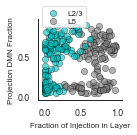

In [5]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot('L2/3', 'projection dmn fraction', data = dat, color='c',
            fit_reg = False,
            label = 'L2/3', scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.6,
                        'zorder':2})
sns.regplot('L5', 'projection dmn fraction', data = dat, color = 'gray',
            fit_reg = False,
            label = 'L5', scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 40,
                        'alpha': 0.6,
                        'zorder': 1})
ax.set_xticks([0, 0.5, 1])
ax.set_xlabel('Fraction of Injection in Layer', fontsize=8)
ax.set_ylabel('Projection DMN Fraction', fontsize = 8)
plt.legend(loc = 2, fontsize = 8, labelspacing = 0.2, 
           bbox_to_anchor = [0,1.2])
sns.despine()
plt.savefig(os.path.join(savepath, 'TD_experiments_by_injection_layer.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [6]:
dat.loc[dat['CAV_percent_DMN']>50, 'target_type'] = 'in DMN'
dat.loc[dat['CAV_percent_DMN']<50, 'target_type'] = 'out DMN'

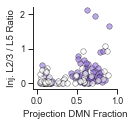

In [10]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot('projection dmn fraction', 'L23_5_ratio', 
            data = dat[dat['target_type'] == 'in DMN'], 
            color='mediumpurple',
            fit_reg = False,
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 30,
                        'alpha': 0.6,
                        'zorder':2})
sns.regplot('projection dmn fraction', 'L23_5_ratio', 
            data = dat[dat['target_type'] == 'out DMN'], 
            color='w',
            fit_reg = False,
            scatter_kws={'edgecolors':'k',
                        'linewidth':0.5,
                        's': 30,
                        'alpha': 0.6,
                        'zorder':2})
ax.set_ylim([-0.15, 2.2])
ax.set_yticks([0, 1, 2])
ax.set_xticks([0, 0.5, 1])
ax.set_ylabel('Inj. L2/3 / L5 Ratio')
ax.set_xlabel('Projection DMN Fraction')
ax.tick_params(bottom = True, left = True)
sns.despine()
plt.savefig(os.path.join(savepath, 'TD_experiments_by_injection_layer_ratio.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [9]:
meltdat = dat[['projection dmn fraction', 'L2/3', 'L5']].melt(
    id_vars = ['L2/3', 'L5'], value_vars = 'projection dmn fraction')

In [10]:
meltdat.head()

,L2/3,L5,variable,value
0,0.305025,0.662901,projection dmn fraction,0.607414
1,0.030346,0.969654,projection dmn fraction,0.652964
2,0.007064,0.983504,projection dmn fraction,0.628588
3,0.035084,0.949610,projection dmn fraction,0.537213
4,0.299050,0.685955,projection dmn fraction,0.682600


In [11]:
meltdat.rename(columns = {'L2/3': 'L2_3'}, inplace = True)
X = meltdat["L2_3"]
y = meltdat["value"]
X = sm.add_constant(X) ## add an intercept

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/opt/anaconda3/envs/DMN/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     40.60
Date:                Wed, 11 Mar 2020   Prob (F-statistic):           3.09e-09
Time:                        15:52:37   Log-Likelihood:                 4.1655
No. Observations:                 130   AIC:                            -4.331
Df Residuals:                     128   BIC:                             1.404
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3222      0.028     11.322      0.000       0.266       0.378
L2_3           0.9469      0.149      6.371      0.000       0.653       1.241
==============================================================================
Omnibus:                       31.049   Durbin-Watson:                   0.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.595
Skew:                           0.032   Prob(JB):                       0.0370
Kurtosis:                       1.898   Cond. No.                         7.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
X = meltdat["L5"]
y = meltdat["value"]
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.849
Date:                Wed, 11 Mar 2020   Prob (F-statistic):              0.176
Time:                        15:52:37   Log-Likelihood:                -12.808
No. Observations:                 130   AIC:                             29.62
Df Residuals:                     128   BIC:                             35.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3343      0.086      3.895      0.000       0.164       0.504
L5             0.1641      0.121      1.360      0.176      -0.075       0.403
==============================================================================
Omnibus:                      131.664   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.425
Skew:                          -0.117   Prob(JB):                      0.00545
Kurtosis:                       1.633   Cond. No.                         7.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
pltdat = dat[['source', 'L2/3', 'projection dmn fraction',
              'CAV_percent_DMN']].melt(id_vars = ['source', 'CAV_percent_DMN'],
                                       value_vars = 'L2/3')
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
pltdat.loc[pltdat['source'].isin(in_strs), 'in-out'] = 'in'
pltdat.loc[~pltdat['source'].isin(in_strs), 'in-out'] = 'out'
pltdat.loc[pltdat['CAV_percent_DMN']>50, 'Target Type'] = 'in DMN'
pltdat.loc[pltdat['CAV_percent_DMN']<50, 'Target Type'] = 'out DMN'

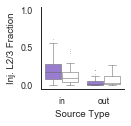

In [14]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.boxplot('in-out', 'value', data = pltdat, 
            hue = 'Target Type', palette = ['mediumpurple', 'white'],
            hue_order = ['in DMN', 'out DMN'],
            fliersize = 0.1, linewidth = 0.5)
sns.despine()
ax.set_ylim([-0.05,1.05])
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Inj. L2/3 Fraction')
ax.set_xlabel('Source Type')
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'TD_experiments_L23_frac_by_in-out.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

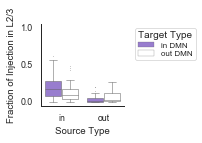

In [15]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.boxplot('in-out', 'value', data = pltdat, 
            hue = 'Target Type', palette = ['mediumpurple', 'white'],
            hue_order = ['in DMN', 'out DMN'],
            fliersize = 0.1, linewidth = 0.5)
sns.despine()
ax.set_ylim([-0.05,1.05])
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Fraction of Injection in L2/3')
ax.set_xlabel('Source Type')
plt.legend(loc = 1, labelspacing = 0.2, fontsize = 8, title='Target Type',
          bbox_to_anchor = [1.9,1])
plt.savefig(os.path.join(savepath, 'TD_experiments_layer_frac_by_in-out_legend.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [16]:
pltdat = dat[['source', 'L5', 'projection dmn fraction',
              'CAV_percent_DMN']].melt(id_vars = ['source', 'CAV_percent_DMN'],
                                       value_vars = 'L5')
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
pltdat.loc[pltdat['source'].isin(in_strs), 'in-out'] = 'in'
pltdat.loc[~pltdat['source'].isin(in_strs), 'in-out'] = 'out'
pltdat.loc[pltdat['CAV_percent_DMN']>50, 'Target Type'] = 'in DMN'
pltdat.loc[pltdat['CAV_percent_DMN']<50, 'Target Type'] = 'out DMN'

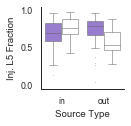

In [17]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.boxplot('in-out', 'value', data = pltdat, 
            hue = 'Target Type', palette = ['mediumpurple', 'white'],
            hue_order = ['in DMN', 'out DMN'],
            fliersize = 0.1, linewidth = 0.5)
sns.despine()
ax.set_ylim([-0.05,1.05])
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Inj. L5 Fraction')
ax.set_xlabel('Source Type')
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'TD_experiments_L5_frac_by_in-out.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [18]:
dat.loc[dat['source'].isin(in_strs), 'in_out'] = 'in'
dat.loc[~dat['source'].isin(in_strs), 'in_out'] = 'out'
dat.loc[dat['CAV_percent_DMN']>50, 'target_type'] = 'in DMN'
dat.loc[dat['CAV_percent_DMN']<50, 'target_type'] = 'out DMN'

In [19]:
dat.head()

,image_series_id,specimen_name,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,primary_injection_structure,source,...,Rbp4_Syp,match comments,L1,L2/3,L4,L5,L6,L23_5_ratio,in_out,target_type
0,475829896,Ai75(RCL-nT)-176762,M,"[39, 48, 993]",0.055739,4920.0,1410.0,5420.0,39.0,ACAd,...,1.0,NaN,0.029921,0.305025,0.0,0.662901,0.002153,0.460137,in,in DMN
1,649362978,Ai75(RCL-nT)-342002,M,"[39, 48, 993]",0.020209,3990.0,1860.0,5340.0,39.0,ACAd,...,0.0,NaN,0.000000,0.030346,0.0,0.969654,0.000000,0.031296,in,in DMN
2,567301515,Ai75(T503)-284534,M,"[39, 48, 993]",0.009040,5260.0,1280.0,5210.0,39.0,ACAd,...,0.0,NaN,0.000000,0.007064,0.0,0.983504,0.009431,0.007183,in,out DMN
3,607059419,Ai75(T601)-333321,F,"[39, 48, 993]",0.068628,5400.0,1410.0,5430.0,39.0,ACAd,...,1.0,NaN,0.000000,0.035084,0.0,0.949610,0.015307,0.036945,in,in DMN
4,607321130,Ai75(T601)-331322,M,"[39, 48]",0.007219,5020.0,1920.0,5370.0,39.0,ACAd,...,1.0,NaN,0.014995,0.299050,0.0,0.685955,0.000000,0.435962,in,in DMN


In [20]:
dat.rename(columns = {'L2/3': 'L2_3'}, inplace = True)
formula = 'L2_3~C(in_out)*C(target_type)'
model = ols(formula, dat).fit()
aov_table = sm.stats.anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(in_out),0.3891,1.0,24.8289,0.0000
C(target_type),0.0337,1.0,2.1523,0.1448
C(in_out):C(target_type),0.0700,1.0,4.4690,0.0365
Residual,1.9744,126.0,NaN,NaN


(0.9112744331359863, 3.21608524700423e-07)


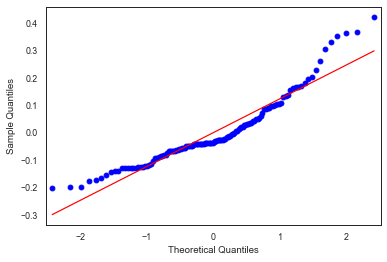

In [21]:
print(stats.shapiro(model.resid))
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [22]:
mc = MultiComparison(dat[dat['in_out'] == 'in']['L2_3'], 
                    dat[dat['in_out'] == 'in']['target_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff  lower   upper  reject
----------------------------------------------
in DMN out DMN -0.0713  -0.1392 -0.0034  True 
----------------------------------------------


In [23]:
mc = MultiComparison(dat[dat['in_out'] == 'out']['L2_3'], 
                    dat[dat['in_out'] == 'out']['target_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff  lower  upper reject
--------------------------------------------
in DMN out DMN  0.0268  -0.0144 0.068 False 
--------------------------------------------


In [24]:
formula = 'L5~C(in_out)*C(target_type)'
model = ols(formula, dat).fit()
aov_table = sm.stats.anova_lm(model, typ=2) #http://www.utstat.utoronto.ca/reid/sta442f/2009/typeSS.pdf
aov_table.round(4)

,sum_sq,df,F,PR(>F)
C(in_out),0.1626,1.0,4.4883,0.0361
C(target_type),0.0013,1.0,0.0367,0.8485
C(in_out):C(target_type),0.2320,1.0,6.4033,0.0126
Residual,4.5650,126.0,NaN,NaN


(0.9520144462585449, 0.0001623173156986013)


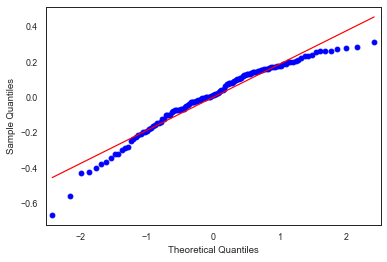

In [25]:
print(stats.shapiro(model.resid))
res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

In [26]:
mc = MultiComparison(dat[dat['in_out'] == 'in']['L5'], 
                    dat[dat['in_out'] == 'in']['target_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff  lower  upper  reject
---------------------------------------------
in DMN out DMN  0.0628  -0.0199 0.1455 False 
---------------------------------------------


In [27]:
mc = MultiComparison(dat[dat['in_out'] == 'out']['L5'], 
                    dat[dat['in_out'] == 'out']['target_type'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff  lower  upper  reject
---------------------------------------------
in DMN out DMN -0.1157  -0.2365 0.0052 False 
---------------------------------------------


In [50]:
pltdat = dat[['source', 'L23_5_ratio', 'projection dmn fraction',
              'CAV_percent_DMN']].melt(id_vars = ['source', 'CAV_percent_DMN'],
                                       value_vars = 'L23_5_ratio')
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
pltdat.loc[pltdat['source'].isin(in_strs), 'in-out'] = 'in'
pltdat.loc[~pltdat['source'].isin(in_strs), 'in-out'] = 'out'
pltdat.loc[pltdat['CAV_percent_DMN']>50, 'Target Type'] = 'in DMN'
pltdat.loc[pltdat['CAV_percent_DMN']<50, 'Target Type'] = 'out DMN'

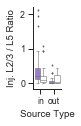

In [51]:
fig, ax = plt.subplots(figsize = (0.5, 1.5))
sns.boxplot('in-out', 'value', data = pltdat, 
            hue = 'Target Type', palette = ['mediumpurple', 'white'],
            hue_order = ['in DMN', 'out DMN'],
            fliersize = 1, linewidth = 0.5)
sns.despine()
ax.tick_params(bottom = True, left = True)
ax.set_ylim([-0.15,2.2])
ax.set_yticks([0, 1, 2])
ax.set_ylabel('Inj. L2/3 / L5 Ratio')
ax.set_xlabel('Source Type')
ax.legend_.remove()
plt.savefig(os.path.join(savepath, 'TD_experiments_L235_ratio_by_in-out.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [52]:
print(len(pltdat['source'].unique()))
for source in pltdat['source'].unique():
    if len(pltdat[(pltdat['source'] == source) &
                 (pltdat['CAV_percent_DMN'] > 50)]) == 0 or len(
        pltdat[(pltdat['source'] == source) &
                 (pltdat['CAV_percent_DMN'] < 50)]) == 0:
        pltdat = pltdat[pltdat['source'] != source]
print(len(pltdat['source'].unique()))

26
13


In [53]:
plot_order = ['ACAd', 'PL', 'ILA', 'ORBl','ORBvl', 
              'VISam', 'RSPd', 'RSPv', 'RSPagl', 
              'MOs', 'TEa','VISl', 'VISp']

In [54]:
print([source for source in pltdat['source'].unique() if source not in plot_order])
print([source for source in plot_order if source not in pltdat['source'].unique()])

[]
[]


In [55]:
pltdat['value'].max()

1.9390630276832348

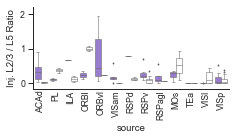

In [56]:
fig, ax = plt.subplots(figsize = (3.5, 1.5))
sns.boxplot('source', 'value', data = pltdat, order = plot_order, 
            hue = 'Target Type', palette = ['mediumpurple', 'white'],
            hue_order = ['in DMN', 'out DMN'],
            fliersize = 1, linewidth = 0.5)
plt.xticks(rotation = 90);
ax.tick_params(left = True)
sns.despine()
ax.legend_.remove()
ax.tick_params('x', pad = -3)
ax.set_ylim([-0.15, 2.2])
ax.set_yticks([0, 1, 2]);
ax.set_ylabel('Inj. L2/3 / L5 Ratio')
plt.savefig(os.path.join(savepath, 'TD_experiments_L235_ratio_by_source.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent = True, dpi=300)

In [57]:
def assign_module(df):
    df.loc[df['source'].isin(['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 
                                                    'ILA', 'PL', 'FRP']), 'module'] = 'Prefrontal'
    df.loc[df['source'].isin(['VISam', 'RSPagl', 'RSPv', 'VISpm',
                                                    'VISa', 'RSPd']), 'module'] = 'Medial'
    df.loc[df['source'].isin(['SSp-tr', 'SSp-ll', 'SSp-bfd', 'SSp-un',
                                                    'SSp-ul', 'MOs', 'MOp', 'SSs', 'SSp-n',
                                                    'SSp-m']), 'module'] = 'Somatomotor'
    df.loc[df['source'].isin(['VISal', 'VISl', 'VISli', 'VISp', 'VISpl',
                                                    'VISpor', 'VISrl']), 'module'] = 'Visual'
    df.loc[df['source'].isin(['AUDpo', 'AUDd', 'AUDp', 'AUDv']), 
                    'module'] = 'Auditory'
    df.loc[df['source'].isin(['TEa', 'PERI', 'ECT', 'GU', 'AId', 'AIv',
                                                    'AIp', 'VISC']), 'module'] = 'Lateral'
    print(len(df[df['module'].isnull()]))
    return df

In [58]:
pltdat.head()

,source,CAV_percent_DMN,variable,value,in-out,Target Type
0,ACAd,100.000000,L23_5_ratio,0.460137,in,in DMN
1,ACAd,85.811661,L23_5_ratio,0.031296,in,in DMN
2,ACAd,0.000000,L23_5_ratio,0.007183,in,out DMN
3,ACAd,100.000000,L23_5_ratio,0.036945,in,in DMN
4,ACAd,100.000000,L23_5_ratio,0.435962,in,in DMN


0


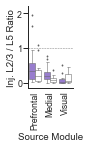

In [61]:
pltdat = assign_module(pltdat)
mod_order = ['Prefrontal', 'Medial', 'Visual']
fig, ax = plt.subplots(1, figsize = (0.8, 1.5))
sns.boxplot('module', 'value', data = pltdat, 
            order = mod_order, ax = ax, 
            hue = 'Target Type', hue_order = ['in DMN', 'out DMN'],
            palette = ['mediumpurple', 'w'],
            fliersize = 1, linewidth = 0.5)
ax.tick_params(top = False, right = False)
ax.set_ylim([-0.15, 2.2])
plt.yticks([0, 1, 2])
plt.xticks(rotation = 90)
ax.set_xlabel("Source Module")
ax.set_ylabel("Inj. L2/3 / L5 Ratio")
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 3
ax.tick_params(top = False, right = False, left = True, bottom = False, pad = 1)
ax.tick_params(axis = 'x', pad=-2)
ax.legend_.remove()
sns.despine()
ax.axhline(y=1, xmin=0, xmax=1, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'TD_L235_ratio_by_module.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [40]:
dat.loc[dat['target_by_polygon'].isin(['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 
                                        'ILA', 'PL', 'FRP']), 'target_module'] = 'Prefrontal'
dat.loc[dat['target_by_polygon'].isin(['VISam', 'RSPagl', 'RSPv', 'VISpm',
                                        'VISa', 'RSPd']), 'target_module'] = 'Medial'
dat.loc[dat['target_by_polygon'].isin(['SSp-tr', 'SSp-ll', 'SSp-bfd', 'SSp-un',
                                        'SSp-ul', 'MOs', 'MOp', 'SSs', 'SSp-n',
                                        'SSp-m']), 'target_module'] = 'Somatomotor'
dat.loc[dat['target_by_polygon'].isin(['VISal', 'VISl', 'VISli', 'VISp', 'VISpl',
                                        'VISpor', 'VISrl']), 'target_module'] = 'Visual'
dat.loc[dat['target_by_polygon'].isin(['AUDpo', 'AUDd', 'AUDp', 'AUDv']), 
                    'target_module'] = 'Auditory'
dat.loc[dat['target_by_polygon'].isin(['TEa', 'PERI', 'ECT', 'GU', 'AId', 'AIv',
                                        'AIp', 'VISC']), 'target_module'] = 'Lateral'
print(len(dat[dat['target_module'].isnull()]))


7


In [41]:
dat[dat['target_module'].isnull()]['target_by_polygon']

2     POST
20    ENTl
21    ENTm
42    ENTl
66    ENTm
67    ENTm
68    POST
Name: target_by_polygon, dtype: object

In [42]:
dat['target_module'].unique()

array(['Somatomotor', 'Prefrontal', nan, 'Medial', 'Visual', 'Lateral',
       'Auditory'], dtype=object)

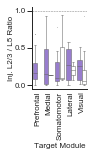

In [43]:
mod_order = ['Prefrontal', 'Medial', 'Somatomotor', 'Lateral', 'Visual']
fig, ax = plt.subplots(1, figsize = (1, 1.5))
sns.boxplot('target_module', 'L23_5_ratio', data = dat, 
            order = mod_order, ax = ax, 
            hue = 'target_type', hue_order = ['in DMN', 'out DMN'],
            palette = ['mediumpurple', 'w'],
            fliersize = 0.1, linewidth = 0.5)
ax.tick_params(top = False, right = False)
ax.set_ylim([-0.05, 1.05])
plt.yticks([0, 0.5, 1], fontsize = 8)
plt.xticks(rotation = 90, fontsize = 8)
ax.set_xlabel("Target Module", fontsize = 8)
ax.set_ylabel("Inj. L2/3 / L5 Ratio", fontsize = 8)
ax.yaxis.labelpad = 1
ax.xaxis.labelpad = 3
ax.tick_params(top = False, right = False, left = True, bottom = False, pad = 1)
ax.tick_params(axis = 'x', pad=-2)
ax.legend_.remove()
sns.despine()
ax.axhline(y=1, xmin=0, xmax=1, color = 'grey', linestyle = 'dashed', 
           linewidth = 0.5, zorder = -1)
plt.savefig(os.path.join(savepath, 'TD_L235_ratio_by_target_module.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)